In [ ]:
# 이 셀 실행 후 세션 다시 시작
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 이 셀 실행 후 세션 다시 시작
!pip install konlpy gensim fasttext matplotlib scikit-learn -q


# 1.Ngram

In [ ]:
from collections import defaultdict, Counter
from konlpy.tag import Okt
# 형태소 분석기 및 토크나이저
okt = Okt()
# 학습할 텍스트 데이터
text = """
하늘을 보니 날씨가 참 좋네요.
하늘을 보니 구름이 있네요.
하늘을 보니 날씨가 좋네요
하늘을 보니 비가 내리네요
하늘을 보니 우울하네요
하늘을 보니 날씨가 안좋네요
하늘을 보니 날씨가 안좋네요
하늘을 보니 날씨가 안좋네요
하늘을 보니 비가 오네요
하늘을 보니 힘드네요
"""

# 텍스트를 토크나이즈
tokens = okt.morphs(text)

# 바이그램을 생성하는 함수
def make_bigrams(tokens):
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
    return bigrams

# 바이그램 만들기
bigrams = make_bigrams(tokens)

# 다음 단어를 예측하기 위해 바이그램 빈도수 계산
bigram_freq = defaultdict(Counter)
for w1, w2 in bigrams:
    bigram_freq[w1][w2] += 1

# n-1 gram을 입력받아 n-gram을 예측하는 함수
def predict_next_word(input_phrase, bigram_freq):
    # 입력된 문장을 형태소 분석 (n-1 gram)
    input_tokens = okt.morphs(input_phrase)

    # 마지막 단어를 기준으로 예측
    last_word = input_tokens[-1]

    if last_word in bigram_freq:
        # 다음에 올 확률이 가장 높은 단어 반환
        return bigram_freq[last_word].most_common(1)[0][0]
    else:
        return None

# 예측 테스트
input_phrase = "하늘을 보니"
predicted_word = predict_next_word(input_phrase, bigram_freq)
print(f"'{input_phrase}' 다음에 올 단어는 '{predicted_word}'입니다.")


'하늘을 보니' 다음에 올 단어는 '날씨'입니다.


In [ ]:
## 빅데이터분석시 Ngram 모델 사용방법 (텍스트마이닝)

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 형태소 분석기 및 토크나이저
okt = Okt()

# 텍스트 데이터를 형태소 단위로 분석하여 명사, 형용사, 동사만 추출하는 함수
def tokenizer(text):
    morph = okt.pos(text)
    words = []
    for word, tag in morph:
        if tag in ['Noun', 'Adjective', 'Verb']:
            if len(word) > 1:  # 한 글자보다 긴 단어만 선택
                words.append(word)
    return words

# 입력 텍스트 데이터 (예시)
text_data = [
    "나는 어제 영어 공부를 열심히 했다",
    "하늘을 보니 날씨가 참 좋네요",
    "오늘은 기분이 좋아요",
    "내일도 공부를 할 예정입니다"
]

# 형태소 분석 및 명사, 형용사, 동사 추출 후, 토크나이즈된 데이터를 다시 텍스트 형식으로 변환
tokenized_text_data = [' '.join(tokenizer(text)) for text in text_data]

# CountVectorizer를 사용하여 n-gram을 생성하고 빈도를 계산합니다.
# ngram_range=(n, m)에서 n과 m을 설정하여 n-gram의 범위를 지정할 수 있습니다.
cv = CountVectorizer(max_features=3000, ngram_range=(2, 2))

# 텍스트 데이터를 n-gram 기반으로 변환
tdm = cv.fit_transform(tokenized_text_data)

# 단어와 그 빈도수를 담은 데이터프레임 생성
word_count_tf = pd.DataFrame({
    '단어': cv.get_feature_names_out(),
    '빈도': tdm.sum(axis=0).flat
})

# 단어 빈도수를 기준으로 내림차순 정렬
word_count_tf = word_count_tf.sort_values('빈도', ascending=False)

# 결과 출력
print(word_count_tf)


        단어  빈도
0    공부 예정   1
1    공부 했다   1
2   기분 좋아요   1
3   날씨 좋네요   1
4    내일 공부   1
5    보니 날씨   1
6    어제 영어   1
7    영어 공부   1
8   예정 입니다   1
9    오늘 기분   1
10   하늘 보니   1


#2.fasttext 및 Word2Vec

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


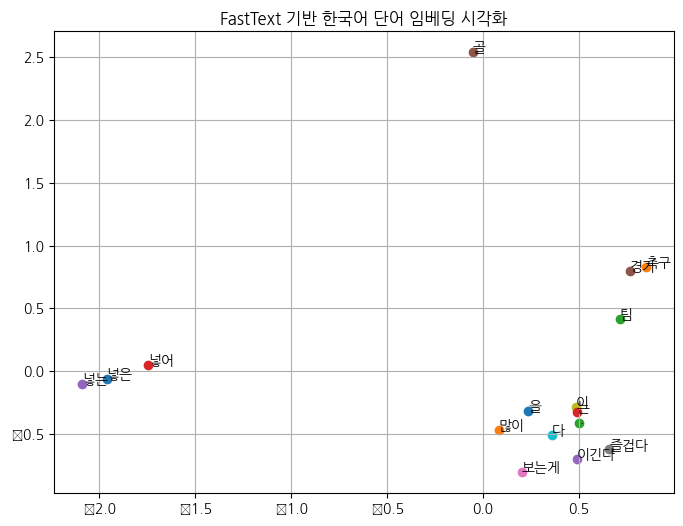

In [ ]:
import fasttext
import fasttext.util
from konlpy.tag import Okt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 폰트 설정 (Colab에서는 나눔고딕 폰트 필요 시 다운로드)
plt.rc('font', family='NanumGothic')  # 혹은 설치된 다른 한글 폰트 사용

# 형태소 분석
okt = Okt()
text = "축구는 골을 많이 넣은 팀이 이긴다. 축구는 골을 넣어 보는게 즐겁다. 축구는 골을 넣는 경기다."
tokens = okt.morphs(text)

# FastText 한국어 사전 모델 다운로드 및 로드
fasttext.util.download_model('ko', if_exists='ignore')  # cc.ko.300.bin
ft = fasttext.load_model('cc.ko.300.bin')

# 단어 벡터 가져오기
word_list = list(set(tokens))  # 중복 제거
word_vectors = np.array([ft.get_word_vector(word) for word in word_list])

# PCA로 차원 축소
pca = PCA(n_components=2)
reduced = pca.fit_transform(word_vectors)

# 시각화
plt.figure(figsize=(8, 6))
for i, word in enumerate(word_list):
    x, y = reduced[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y))
plt.title("FastText 기반 한국어 단어 임베딩 시각화")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


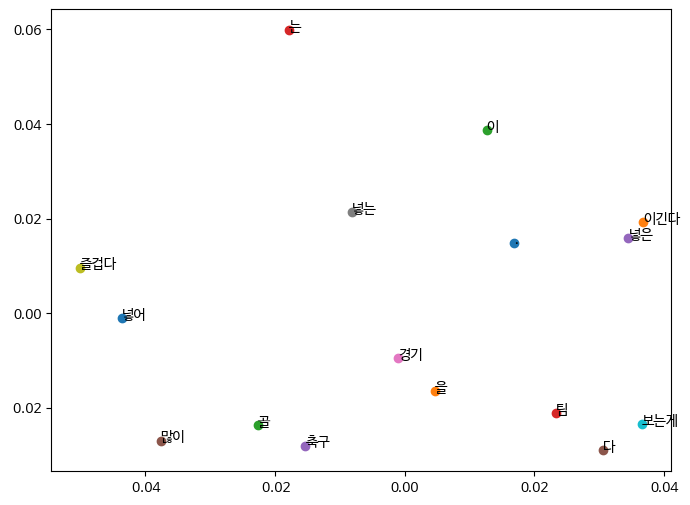

In [ ]:
from gensim.models import Word2Vec
from konlpy.tag import Okt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 한글 폰트 설정
# 시각화할 때 한글이 깨지지 않도록 폰트를 설정합니다.
plt.rc('font', family='NanumBarunGothic')

# Okt 형태소 분석기 초기화
# 한국어 텍스트 처리를 위해 Okt 형태소 분석기를 사용합니다.
okt = Okt()

# 학습할 텍스트 예시
# 실제로 텍스트 데이터에서 단어 관계를 분석합니다.
text = "축구는 골을 많이 넣은 팀이 이긴다. 축구는 골을 넣어 보는게 즐겁다. 축구는 골을 넣는 경기다."

# 텍스트를 토큰화 (형태소 단위로 분리)
# 문장을 형태소 단위로 쪼개어 토큰화합니다.
tokens = okt.morphs(text)

# Word2Vec 모델 학습
# Word2Vec 모델을 통해 토큰화된 단어들의 벡터를 학습합니다.
model = Word2Vec([tokens], vector_size=50, window=5, min_count=1, sg=1)

# 단어 벡터 추출
# 학습된 모델에서 각 단어의 벡터를 추출합니다.
word_vectors = model.wv.vectors

# PCA로 2D로 축소
# 단어 벡터는 고차원(50차원)이므로 이를 시각화하기 위해 2차원으로 줄입니다.
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# 단어와 좌표를 시각화
# PCA로 축소된 좌표를 시각화하고, 각 단어에 라벨을 달아줍니다.
plt.figure(figsize=(8,6))
words = model.wv.index_to_key  # 모델의 단어 리스트

# 각 단어의 좌표를 차트에 표시하고, 단어 라벨을 붙여줍니다.
for i, word in enumerate(words):
    plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1])
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# 그래프를 출력하여 시각적으로 확인합니다.
plt.show()


# 3.RNN 모델


In [ ]:
# 아래 RNN 코드는 간단한 문장을 학습하여, 입력된 단어 시퀀스를 기반으로 다음에 나올 단어를 예측하는 모델입니다.
# 1. 텍스트 데이터를 단어 단위로 토큰화하고, 이를 n-gram 시퀀스로 변환합니다.
# 2. n-gram 시퀀스를 RNN 모델의 입력으로 사용하며, RNN은 각 단계에서 이전 정보(은닉 상태)를 사용해 다음 단어를 예측합니다.
# 3. 학습된 모델은 입력된 단어 구문에 대해 다음 단어를 예측할 수 있습니다.
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. 텍스트 데이터 저장 (RNN이 학습할 데이터)
# - RNN이 학습할 텍스트 데이터를 준비합니다. 두 문장으로 이루어진 간단한 예제입니다.
text_data = """나는 미안해서 사과를 했다.친구가 미안한 마음에 한 사과를 받아주었다."""

# 2. 텍스트 전처리 (단어를 인덱스로 변환)
# - Tokenizer를 사용해 단어를 숫자 인덱스로 변환합니다.
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])  # 텍스트에서 단어 인덱스를 학습
total_words = len(tokenizer.word_index) + 1  # 총 단어 수 계산 (1부터 시작하므로 +1)

# 2.1 n-gram 시퀀스 생성
# - 각 문장에서 2개 이상의 단어 조합(n-gram)을 만들어 모델 학습에 사용할 데이터로 만듭니다.
input_sequences = []
for line in text_data.split('.'):  # 마침표로 문장을 나눕니다.
    token_list = tokenizer.texts_to_sequences([line])[0]  # 문장을 인덱스 리스트로 변환
    for i in range(1, len(token_list)):  # n-gram을 생성
        input_sequences.append(token_list[:i+1])

# 2.2 시퀀스 패딩
# - RNN의 입력 시퀀스 길이를 통일하기 위해 패딩(padding)을 적용합니다.
max_sequence_len = max([len(x) for x in input_sequences])  # 가장 긴 시퀀스 길이를 구함
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))  # 0으로 채워 길이 통일

# 2.3 입력(X)과 출력(y) 데이터 분리
# - 입력(X)은 마지막 단어를 제외한 시퀀스, 출력(y)은 마지막 단어입니다.
X = input_sequences[:,:-1]  # 마지막 단어 제외 (입력)
y = input_sequences[:,-1]  # 마지막 단어 (출력)
y = tf.keras.utils.to_categorical(y, num_classes=total_words)  # y를 one-hot 인코딩

# 3. RNN 모델 정의
# - Sequential 모델을 사용하여 간단한 RNN을 정의합니다.
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))  # 단어를 64차원의 벡터로 변환하는 임베딩 레이어
model.add(SimpleRNN(100))  # RNN 레이어 (100개의 은닉 유닛 사용)
model.add(Dense(total_words, activation='softmax'))  # 다음 단어를 예측하는 출력 레이어

# 4. 모델 컴파일 및 학습
# - 모델의 손실 함수, 최적화 방법을 정의하고 학습을 진행합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=1)  # 100번의 에포크 동안 학습

# 5. 다음 단어 예측 함수 정의
# - 이 함수는 주어진 시드 문장(text_seed)에 이어질 다음 단어를 예측합니다.
def predict_next_word(model, tokenizer, text_seed, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text_seed])[0]  # 입력 문장을 인덱스로 변환
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  # 시퀀스 길이 맞추기
    predicted = np.argmax(model.predict(token_list), axis=-1)  # 가장 높은 확률을 가진 단어 인덱스 반환
    for word, index in tokenizer.word_index.items():  # 예측된 인덱스를 실제 단어로 변환
        if index == predicted:
            return word
    return ""  # 예측된 단어가 없으면 빈 문자열 반환


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1250 - loss: 2.3055
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - accuracy: 0.2500 - loss: 2.2404
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5000 - loss: 2.1760
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6250 - loss: 2.1113
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5000 - loss: 2.0451
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6250 - loss: 1.9767
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6250 - loss: 1.9059
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6250 - loss: 1.8326
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6250 - loss: 1.7571
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6250 - loss: 1.6804
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6250 - loss: 1.6036
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

# 1. 텍스트 데이터 저장 (RNN이 학습할 데이터)
# - 학습할 텍스트 데이터를 준비합니다. 이번에는 한국어 예제를 사용합니다.
text_data = """나는 미안해서 사과를 했다. 친구가 미안한 마음에 한 사과를 받아주었다."""

# 2. 형태소 기반 토큰화 (konlpy의 Okt 사용)
# - konlpy의 Okt 형태소 분석기를 사용해 문장을 형태소 단위로 나눕니다.
okt = Okt()
tokens = okt.morphs(text_data)  # 텍스트를 형태소 단위로 분리하여 리스트 형태로 저장

# 2.1 단어 인덱싱
# - 토큰화된 단어를 인덱스로 변환합니다. 단어마다 고유한 숫자를 할당합니다.
tokenizer = tf.keras.preprocessing.text.Tokenizer()  # Keras의 Tokenizer 사용
tokenizer.fit_on_texts([tokens])  # 형태소 리스트를 학습하여 단어 인덱스를 만듭니다.
total_words = len(tokenizer.word_index) + 1  # 총 단어 수 계산 (+1은 인덱스가 1부터 시작하도록)

# 2.2 n-gram 시퀀스 생성
# - n-gram을 사용하여 단어 조합을 만들고, RNN 모델이 학습할 시퀀스를 생성합니다.
input_sequences = []
for i in range(1, len(tokens)):  # 1부터 시작하여 n-gram 시퀀스를 만듭니다.
    token_list = tokenizer.texts_to_sequences([tokens[:i+1]])[0]  # n번째 단어까지의 시퀀스 생성
    input_sequences.append(token_list)

# 2.3 시퀀스 패딩
# - RNN 입력 시퀀스의 길이를 동일하게 맞추기 위해 패딩을 추가합니다.
max_sequence_len = max([len(x) for x in input_sequences])  # 가장 긴 시퀀스 길이 계산
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')  # 시퀀스 패딩 처리

# 2.4 입력(X)과 출력(y) 데이터 분리
# - 입력(X)은 마지막 단어를 제외한 시퀀스, 출력(y)은 마지막 단어입니다.
X = input_sequences[:,:-1]  # 마지막 단어 제외 (입력)
y = input_sequences[:,-1]  # 마지막 단어 (출력)
y = tf.keras.utils.to_categorical(y, num_classes=total_words)  # 출력 데이터(one-hot 인코딩)

# 3. RNN 모델 정의
# - 입력된 단어 시퀀스를 학습해 다음 단어를 예측하는 RNN 모델을 정의합니다.
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))  # 단어를 64차원 벡터로 임베딩
model.add(SimpleRNN(100))  # RNN 레이어: 100개의 은닉 유닛을 사용
model.add(Dense(total_words, activation='softmax'))  # 출력 레이어: 다음 단어를 예측하는 레이어

# 4. 모델 컴파일 및 학습
# - 손실 함수, 최적화 방법을 설정하고 모델 학습을 진행합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # 손실 함수와 옵티마이저 설정
model.fit(X, y, epochs=100, verbose=1)  # 100번의 에포크 동안 학습

# 5. 다음 단어 예측 함수 정의
# - 주어진 문장의 형태소 시퀀스를 기반으로 다음 단어를 예측하는 함수입니다.
def predict_next_word(model, tokenizer, text_seed, max_sequence_len):
    token_list = okt.morphs(text_seed)  # 입력된 문장을 형태소로 토큰화
    token_list = tokenizer.texts_to_sequences([token_list])[0]  # 형태소 리스트를 숫자로 변환
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  # 패딩을 적용해 시퀀스 길이를 맞춤
    predicted = np.argmax(model.predict(token_list), axis=-1)  # 가장 높은 확률을 가진 단어 인덱스를 예측
    for word, index in tokenizer.word_index.items():  # 예측된 인덱스를 단어로 변환
        if index == predicted:
            return word  # 예측된 단어 반환
    return ""  # 예측된 단어가 없으면 빈 문자열 반환


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0625 - loss: 2.7153
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1875 - loss: 2.6138
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4375 - loss: 2.5160
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5625 - loss: 2.4165
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5625 - loss: 2.3124
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5625 - loss: 2.2025
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6250 - loss: 2.0880
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6875 - loss: 1.9732
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6875 - loss: 1.8654
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6875 - loss: 1.7686
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7500 - loss: 1.6792
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.87

In [ ]:
# 6. 예시 입력을 통해 다음 단어 예측
# - 시드 문장을 주고, 모델이 예측한 다음 단어를 확인합니다.
seed_text = "나는 미안해서"
predicted_word = predict_next_word(model, tokenizer, seed_text, max_sequence_len)  # 다음에 올 단어 예측
print(f"'{seed_text}' 다음에 나올 단어는: {predicted_word}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
'나는 미안해서' 다음에 나올 단어는: 사과
